In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
layers = keras.layers

print("keras version", keras.__version__)
print("numpy version", np.__version__)

keras version 2.11.0
numpy version 1.24.2


In [2]:
# Download Fashion MNIST and normalitze it to [0,1]
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = train_images[...,np.newaxis] / 255

In [3]:
len(train_images)

60000

In [4]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

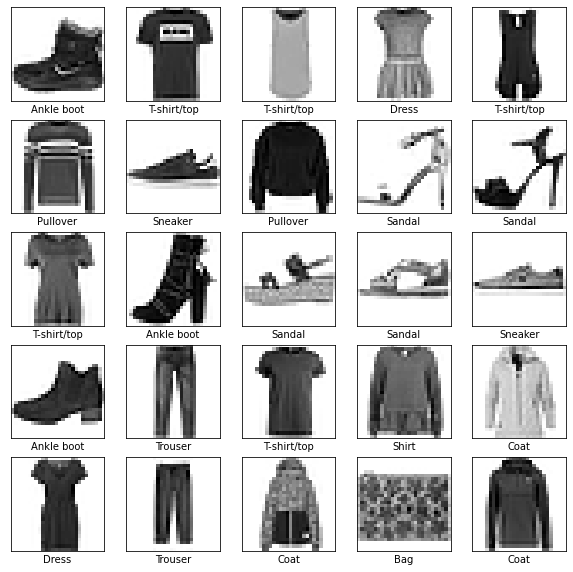

In [5]:
#### check the data we got
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images[i]).astype(int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

### Model 

For current task we might try to use for example generator model (GANs). For training GANs we need to further define our generator and discriminator network. We start by defining our generator network, which should map from our noise + label space into the space of images (latent-vector size --> image size). Adding the label the input of to both the generator and discriminator should enforce the generator to produce samples from the according class

In [6]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(14 * 14 * latent_size)(latent)
    z = layers.BatchNormalization()(z)
    z = layers.Reshape([14, 14, latent_size])(z)
    z = layers.Conv2D(128, (5, 5), padding='same')(z)
    z = layers.UpSampling2D(size=(2, 2))(z)
    z = layers.Conv2D(1, (5, 5), padding='same')(z)
    z = layers.Activation('linear')(z)
    return keras.models.Model(latent, z, name="generator")

In [7]:
# Build and check the shapes of our generator
latent_size = 128 #number of images as part of the embedding
g_model = generator_model(latent_size)
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 25088)             3236352   
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 128)      0         
 )                                                       

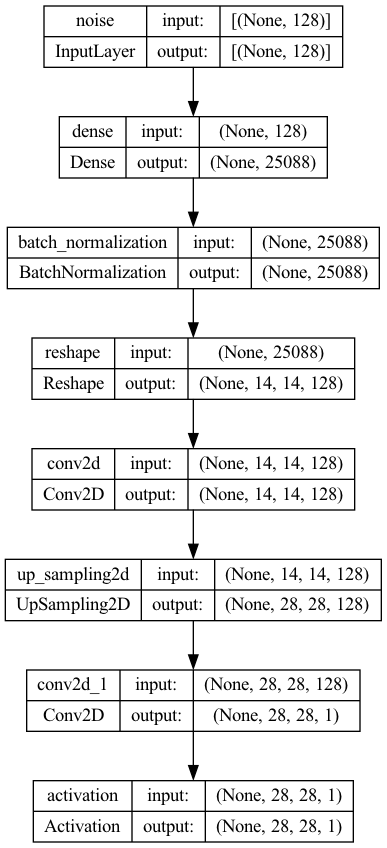

In [8]:
# Plot the Keras model as a graph
from tensorflow.keras.utils import plot_model
# plot_model(g_model, to_file='model.png', show_shapes=True)
plot_model(g_model, show_shapes=True)

### Discriminator
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images. So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images (image size --> scalar). Also, here we add the class label to the discriminator.
(We need a softmax as last activation function in the discriminator)


In [9]:
def discriminator_model(drop_rate=0.25):
    """ Discriminator network """
    image = layers.Input(shape=(28,28,1), name="images")
    x = layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2))(image)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(2)(x)
    x = layers.Activation("softmax")(x)
    return keras.models.Model(image, x, name="discriminator")

In [10]:
from tensorflow.keras.optimizers.legacy import Adam

d_model = discriminator_model()
d_model.summary()
d_opt = Adam(learning_rate=2e-4, beta_1=0.5, decay=0.0005)
d_model.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=["acc"]) # loss='categorical_crossentropy',

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 12546     
                                                                 
 activation_1 (Activation)   (None, 2)               

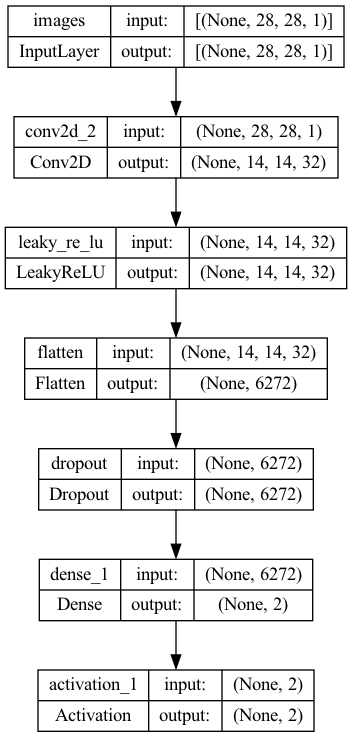

In [11]:
# Plot the Keras model as a graph
# from tensorflow.keras.utils import plot_model
plot_model(d_model, show_shapes=True)

### Training preparations
After building the generator and discriminator, we have to compile it. But before, we have to freeze the weights of the discriminator. (Remember that we have to fix the discriminator weights for training the generator because we want to fool the discriminator by drawing excellent images, not by making our discriminator a worse classifier)

In [12]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

In [13]:
# Note that after we compiled a model, calling make_trainable will have no effect until compiling the model again.

make_trainable(d_model, False)  # freeze the critic during the generator training
print("========")
make_trainable(g_model, True)  # unfreeze the generator during the generator training

<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.activation.leaky_relu.LeakyReLU'>
<class 'keras.layers.reshaping.flatten.Flatten'>
<class 'keras.layers.regularization.dropout.Dropout'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.activation.Activation'>
<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
<class 'keras.layers.reshaping.reshape.Reshape'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.reshaping.up_sampling2d.UpSampling2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.core.activation.Activation'>


We build the pipeline for the generator training by stacking the generator on the discriminator (with frozen weights)

In [14]:
gen_input = g_model.inputs
generator_training = keras.models.Model(gen_input, d_model(g_model(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         3749633   
                                                                 
 discriminator (Functional)  (None, 2)                 13378     
                                                                 
Total params: 3,763,011
Trainable params: 3,699,457
Non-trainable params: 63,554
_________________________________________________________________


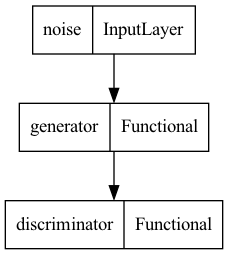

In [15]:
plot_model(generator_training)

In [16]:
g_opt = Adam(learning_rate=2e-4, beta_1=0.5, decay=0.0005)
generator_training.compile(loss='binary_crossentropy', optimizer=g_opt)

In [17]:
# We pre-train the discriminator using 5000 real and 5000 fakes samples (pure noise, since the generator wasn't updated yet)
ntrain = 5000
no = np.random.choice(len(train_images), size=ntrain, replace='False')
real_train = train_images[no,:,:,:]   # sample real images from training set
noise_gen = np.random.uniform(0,1,size=[ntrain, latent_size])
generated_images = g_model.predict(noise_gen)  # generate fake images with untrained generator

X = np.concatenate((real_train, generated_images))
y = np.zeros([2*ntrain, 2])   # class vector: one-hot encoding
y[:ntrain, 1] = 1             # class 1 for real images
y[ntrain:, 0] = 1             # class 0 for generated images

# - Train the discriminator for 1 epoch on this dataset.
d_model.fit(X,y, epochs=1, batch_size=64)

  9/157 [>.............................] - ETA: 2s

2023-02-27 12:38:12.571541: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


157/157 [==============================] - 1s 3ms/step - loss: 0.2532 - acc: 0.9906


Lets try to select a resonable batch size and find a good number of epochs

Number of train images: 60000
Epoch:  0/ 1
1/1 [==============================] - 0s 22ms/step
iteration 1
generator loss 4.403569221496582
discriminator loss 0.06245991960167885
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
iteration 501
generator loss 0.6937064528465271
discriminator loss 0.5191700458526611
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
iteration 1001
generator loss 0.5386534929275513
discriminator loss 0.3051120638847351
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
iteration 1501
generator loss 0.26034820079803467
discriminator loss 0.46664437651634216
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


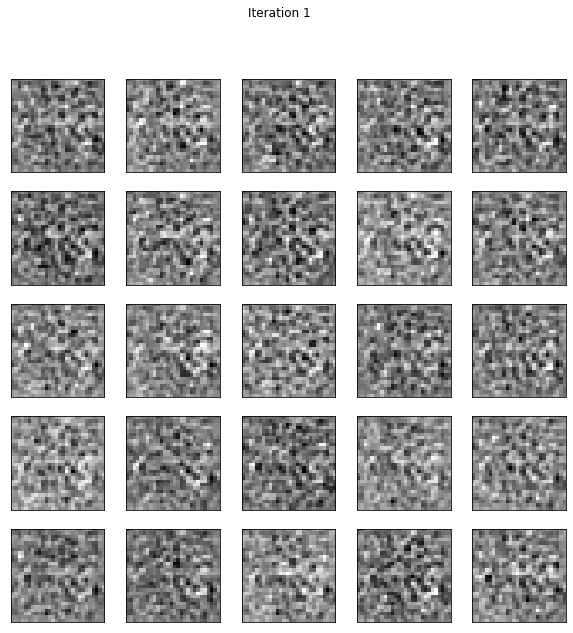

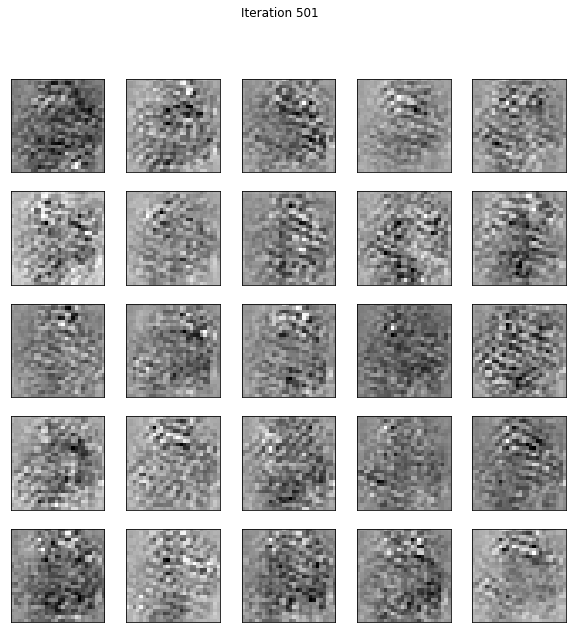

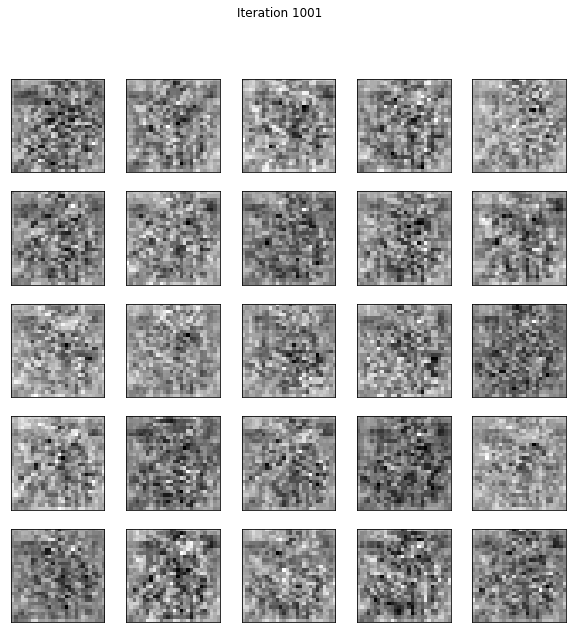

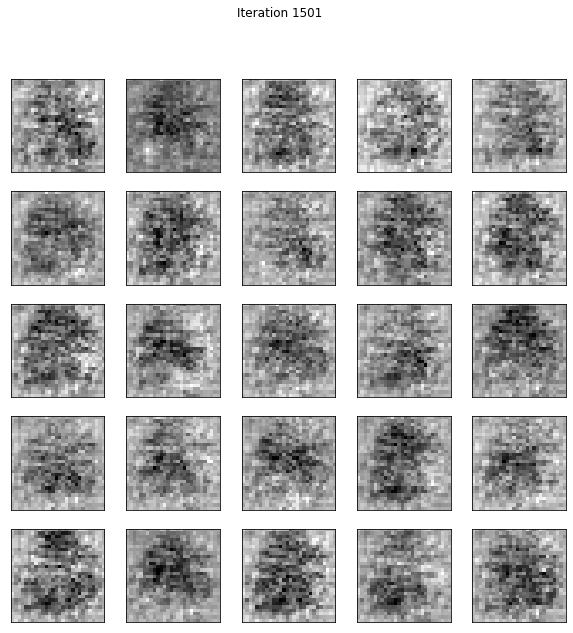

In [18]:
losses = {"discriminator":[], "generator":[]}
discriminator_acc = []
batch_size = 32
nsamples = len(train_images)
print(f"Number of train images: {nsamples}")
iterations_per_epoch = nsamples / batch_size    # number of training steps per epoch len(train_images)
epochs = 1

iters = 0

for epoch in range(epochs):
    print("Epoch: {0:2d}/{1:2d}".format(epoch, epochs))
    perm = np.random.choice(nsamples, size=nsamples, replace='False')

    for i in range(int(iterations_per_epoch)):
        
        # Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
        image_batch = train_images[perm[i*batch_size:(i+1)*batch_size],:,:,:]    # real images   
        noise_gen = np.random.uniform(0.,1.,size=[batch_size, latent_size])
        
        # generate images using the generator
        generated_images = g_model.predict(noise_gen)

        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size,2])  # class vector
        y[0:batch_size,1] = 1
        y[batch_size:,0] = 1
    
        # Train the discriminator on the mini-batch
        d_loss, d_acc  = d_model.train_on_batch(X,y)
        losses["discriminator"].append(d_loss)
        discriminator_acc.append(d_acc)
    
        # Create a new mini-batch of data (X_: noise, y_: class vectors pretending that these produce real images)
        X_ = np.random.uniform(0.,1.,size=[batch_size, latent_size])
        y_ = np.zeros([batch_size,2])
        y_[:,1] = 1
    
        # Train the generator part of the GAN on the mini-batch
        g_loss = generator_training.train_on_batch(X_, y_)
        losses["generator"].append(g_loss)

        iters +=1

        if iters % 500 == 1: 
            # Plot some fake images
            print("iteration", iters)
            print("generator loss", losses["generator"][-1])
            print("discriminator loss", losses["discriminator"][-1])
      
            noise = np.random.uniform(0.,1.,size=[25,latent_size])
            generated_images = g_model.predict(noise)
            plt.figure(figsize=(10,10))
          
            for i in range(25):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                img = plt.imshow((255 * generated_images[i]).astype(int).squeeze(), cmap=plt.cm.binary)
      
            plt.suptitle("Iteration %i" %iters)
            plt.savefig("./fake_fMNIST_iteration_%.6i.png" % iters)


### Results


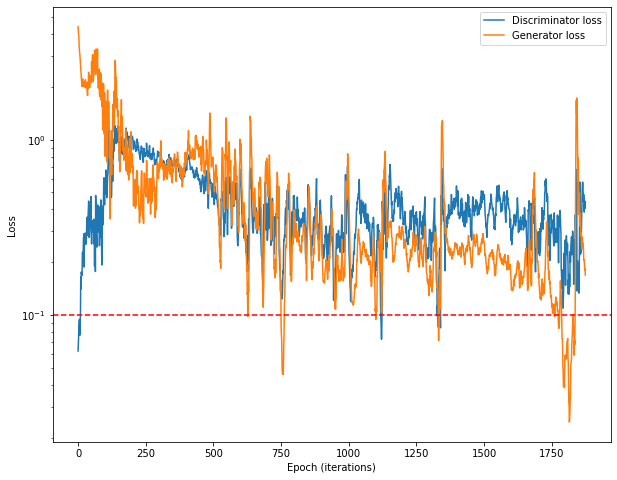

In [29]:
# Plot the loss of the discriminator and the generator as function of iterations
# Create a new figure and axis
# fig, ax = plt.subplots()
plt.figure(figsize=(10,8))
plt.semilogy(losses["discriminator"], label='Discriminator loss')
plt.semilogy(losses["generator"], label='Generator loss')

# Add a horizontal line at y=0
plt.axhline(y=pow(10,-1), color='r', linestyle='--')

plt.ylabel("Loss")
plt.xlabel("Epoch (iterations)")
# plt.xscale('log')
plt.legend()

plt.show()

Monitoring the losses alone may not be sufficient to determine the performance of a GAN. 
It is important to also evaluate the quality of the generated outputs and the discriminative ability of the discriminator, using metrics such as accuracy, precision, recall, and F1 score.

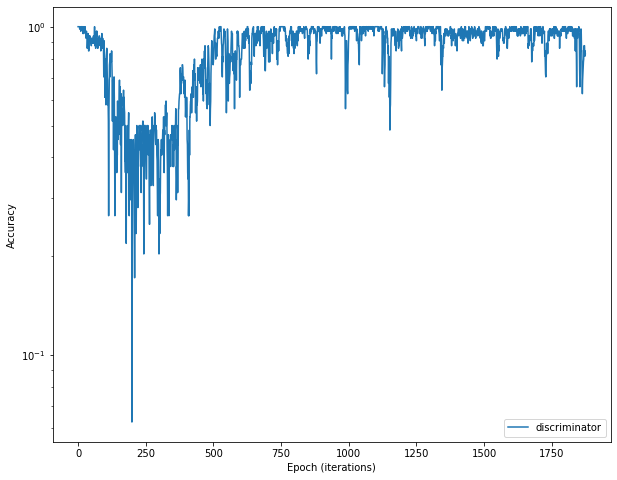

In [28]:
# Plot the accuracy of the discriminator as function of iterations
# Accuracy is a measure of how often a model correctly predicts the correct outcome. 
# It is calculated as the number of correct predictions divided by the total number of predictions. 
plt.figure(figsize=(10,8))
plt.semilogy(discriminator_acc, label='discriminator')
plt.ylabel("Accuracy")
plt.xlabel("Epoch (iterations)")
plt.legend()
plt.show()

### Summary 

In general, the goal of the generator is to produce outputs that are as similar as possible to the real data, while the discriminator's goal is to correctly distinguish between real and fake data.

Ideally, the generator loss should be decreasing over time and eventually stabilize, indicating that the generator is getting better at producing realistic outputs. 
However, the generator loss should not decrease too quickly, as this may indicate that the generator is simply memorizing the training data and not learning to generalize to new data.


The discriminator loss should also be decreasing over time and eventually stabilize, indicating that the discriminator is getting better at distinguishing between real and fake data. 
However, the discriminator loss should not decrease to zero, as this may indicate that the discriminator is overfitting to the training data and will not be able to generalize to new data.

In our case we see from the losses plots and from accuracy that our discriminator model was able to perform nicelly already at 1000 epoch. And we also see tha generatot loss is jumping very much for the high epoch, which is not nice.